# Post-wildfire Vegetation Recovery
## In this Jupyter notebook, we calculate vegetation indices with NEON reflectance data.
Author: Heidi Yoon

In [1]:
# Import packages
import io
import os
import sys
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import h5py
import geopandas as gpd
import earthpy.plot as ep

# Check module path
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
    
import modules.reflectance as refl

The NEON reflectance data is available from the [NEON Data API](https://data.neonscience.org/data-api/). We use the API here to download the data for our analysis.

In [2]:
# Get NEON reflectance data from NEON API
# Endpoints are data product, site, date, and release year
neon_base = "https://data.neonscience.org/api/v0/data"
data_product = "/DP3.30006.001"
site = "/GRSM"
post_fire_release = "/2017-10?package=basic&release=RELEASE-2022"
post_fire_url = neon_base + data_product + site + post_fire_release
post_fire_data = requests.get(post_fire_url)

# Similarly for the pre-fire data
pre_fire_release = "/2016-06?package=basic&release=RELEASE-2022"
pre_fire_url = neon_base + data_product + site + pre_fire_release
pre_fire_data = requests.get(pre_fire_url)

In [3]:
# Using API response, find the url corresponding to tile of interest
post_fire_df = pd.json_normalize(post_fire_data.json()['data']['files'])
pre_fire_df = pd.json_normalize(pre_fire_data.json()['data']['files'])

In [4]:
# Define data directory and data paths
data_dir = os.path.join(project_path, 'data')
post_data_path = os.path.join(
    data_dir, 'NEON_GRSM_274000_3947000_201710_reflectance.h5')
pre_data_path = os.path.join(
    data_dir, 'NEON_GRSM_274000_3947000_201606_reflectance.h5')
chimney_fire_dir = os.path.join(data_dir, 'chimtops2_burn_bndy')
chimney_fire_path = os.path.join(
    chimney_fire_dir, 'chimtops2_burn_bndy.shp')

# Check if data directory exists
try:
    os.makedirs(data_dir)
    print('The data directory has been created!')
except FileExistsError:
    print('The data directory already exists!')

The data directory already exists!


In [5]:
# Get NEON reflectance data
post_url = (
        'https://storage.googleapis.com/neon-aop-products/2017/FullSite/D07/'
        '2017_GRSM_3/L3/Spectrometer/Reflectance/'
        'NEON_D07_GRSM_DP3_274000_3947000_reflectance.h5')
pre_url = (
        'https://storage.googleapis.com/neon-aop-products/2016/FullSite/D07/'
        '2016_GRSM_2/L3/Spectrometer/Reflectance/'
        'NEON_D07_GRSM_DP3_274000_3947000_reflectance.h5')

post_fire_data = refl.download_file(post_data_path, post_url)
pre_fire_data = refl.download_file(pre_data_path, pre_url)

In [6]:
# Get MTBS fire boundary
fire_bound_url = (
        'https://github.com/AreteY/post-wildfire-vegetation-change/files/'
        '8567790/chimtops2_burn_bndy.zip')

fire_bound_data = refl.download_zipfile(
    chimney_fire_path, fire_bound_url, chimney_fire_dir)

In [7]:
# Open NEON data and store reflectance array and metadata
post_fire_refl, post_fire_metadata = refl.aop_h5refl2array(post_data_path)
pre_fire_refl, pre_fire_metadata = refl.aop_h5refl2array(pre_data_path)

In [8]:
# Open fire boundary and reproject crs
chimney_fire_bound = gpd.read_file(chimney_fire_path)
chimney_fire_reproj = chimney_fire_bound.to_crs(epsg=32617)

## <a href="https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/" target="_blank">Vegetation Analysis</a>
We will use three different vegetation indices to evaluate the burned areas after the Chimney Tops 2 Fire.
1. **Normalized Burn Ratio (NBR)**
* NBR uses the spectral response of burned vegetation versus healthy vegetation to identify burned areas.
2. **Normalized Difference Vegetation Index (NDVI)**
* NDVI uses the spectral response of vegetation to quantity the greenness of an area.
3. **Modified Soil Adjusted Vegetation Index (MSAVI)**
* MSAVI is a vegetation index in which the soil-noise background is minimized using a factor that varies inversely with the amount of vegetation present. 
* Reference: Qi, J.; Chehbouni, A.; Huete, A.; Kerr, Y., Sorooshian, S. A modified soil adjusted vegetation index. *Remote Sens. Environ.* **1994**, 48, 119-126. https://doi.org/10.1016/0034-4257(94)90134-1

## Selection of Bands for Vegetation Analysis
The NEON imaging spectrometer measures 426 bands in the range of 383.5343 - 2511.8945 nm, in which each band has a band width of 5 nm.

### For the calculation of NBR, we use band 117 for the NIR band and band 400 for the SWIR band.
* Reference: vanGerrevink, M.J.; Veraverbeke, S. Evaluating the Hyperspectral Sensitivity of the Differenced Normalized Burn Ratio for Assessing Fire Severity. *Remote Sens.* **2021**, 13, 4611. https://doi.org/10.3390/rs13224611

### For the calculation of NDVI and MSAVI, we use band 58 for the Red band and band 84 for the NIR band. 
* Reference: Meng, R.; Wu, J.; Feng, Z.; Cook, B. D.; Hanavan, R. P.; Serbin, S. P. Measuring short-term post-fire forest recovery across a burn severity gradient in a mixed pine-oak forest using multi-sensor remote sensing techniques. *Remote Sens. Environ.* **2018**, 210, 282-296. https://doi.org/10.1016/j.rse.2018.03.019

In [9]:
print('Band 58 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][57]),'nm')
print('Band 84 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][83]),'nm')
print('Band 117 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][116]),'nm')
print('Band 400 Center Wavelength = %.2f' %(
    post_fire_metadata['wavelength'][399]),'nm')

Band 58 Center Wavelength = 668.98 nm
Band 84 Center Wavelength = 799.19 nm
Band 117 Center Wavelength = 964.45 nm
Band 400 Center Wavelength = 2381.69 nm


In [10]:
print('Band 58 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][57]),'nm')
print('Band 84 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][83]),'nm')
print('Band 117 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][116]),'nm')
print('Band 400 Center Wavelength = %.2f' %(
    pre_fire_metadata['wavelength'][399]),'nm')

Band 58 Center Wavelength = 669.10 nm
Band 84 Center Wavelength = 799.30 nm
Band 117 Center Wavelength = 964.55 nm
Band 400 Center Wavelength = 2381.74 nm


### We will subset and stack these bands in the following order: 
* Bands 58, 84, 117, 400; or Red, NIR (vegetation index), NIR (burn ratio), SWIR.

In [11]:
# Stack and subset bands of interest
pre_fire_stack = refl.stack_subset_bands(
    pre_fire_refl, pre_fire_metadata, (58, 84, 117, 400))

In [12]:
post_fire_stack = refl.stack_subset_bands(
    post_fire_refl, post_fire_metadata, (58, 84, 117, 400))

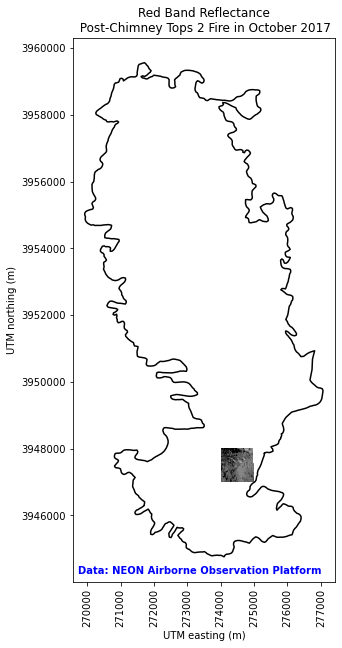

In [13]:
# Plot an example reflectance tile within the fire boundary
f, ax = plt.subplots(figsize=(10, 10))

# Define raster image
plt.imshow(post_fire_refl[:, :, 0], 
           extent=post_fire_metadata['extent'], 
           cmap='Greys', 
           clim=(0, 1200))

# Add fire boundary
chimney_fire_reproj.boundary.plot(ax=ax, color="black")

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and label axes
ax.set(title='Red Band Reflectance\n Post-Chimney Tops 2 Fire in October 2017',
       xlabel='UTM easting (m)',
       ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Data: NEON Airborne Observation Platform", va='bottom',
        ha='right', transform=ax.transAxes, color="blue", fontweight='bold')

plt.show()

* The vegetation analysis will be conducted on one specific tile. Here is a map showing the location of the tile within the Chimney Tops 2 fire boundary.

### 1. Normalized Burn Ratio (NBR)
* $NBR=\frac{(NIR-SWIR)}{(NIR+SWIR)}$
* The Difference Normalized Burn Ratio (dNBR) is the difference between the pre-fire NBR and the post-fire NBR.

In [14]:
# Calculate NBR
post_fire_nbr = refl.calc_norm_diff(
    post_fire_stack[:, :, 2], post_fire_stack[:, :, 3])

pre_fire_nbr = refl.calc_norm_diff(
    pre_fire_stack[:, :, 2], pre_fire_stack[:, :, 3])

# Calculate dNBR
dnbr = pre_fire_nbr - post_fire_nbr

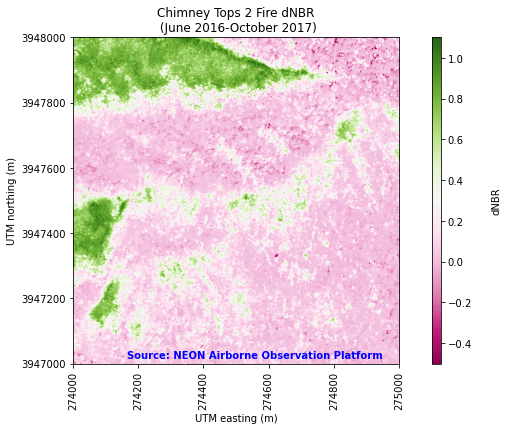

In [16]:
# Plot dNBR
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(dnbr,
                 extent=post_fire_metadata['extent'],
                 cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('dNBR', rotation=90, labelpad=20)
plot.set_clim(-0.5, 1.1)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(title='Chimney Tops 2 Fire dNBR\n (June 2016-October 2017)',
       xlabel='UTM easting (m)',
       ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: NEON Airborne Observation Platform", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

* The plot of the difference between the pre-post NBR shows significant burned areas still exist almost one-year after the Chimney Tops 2 Fire. Regions above dNBR = 0.1 represent burn areas, whereas regions below dNBR = -0.1 represent regrowth.

### 2. Normalized Difference Vegetation Index (NDVI)
* $NDVI=\frac{(NIR-Red)}{(NIR+Red)}$
* The difference NDVI is the difference between the post-fire NDVI and the pre-fire NDVI.

In [17]:
# Calculate NDVI using earthpy.spatial normalized_diff() function
post_fire_ndvi = refl.calc_norm_diff(
    post_fire_stack[:,:,1], post_fire_stack[:,:,0])
pre_fire_ndvi = refl.calc_norm_diff(
    pre_fire_stack[:,:,1], pre_fire_stack[:,:,0])

# Calculate diff NDVI
diff_ndvi = post_fire_ndvi - pre_fire_ndvi

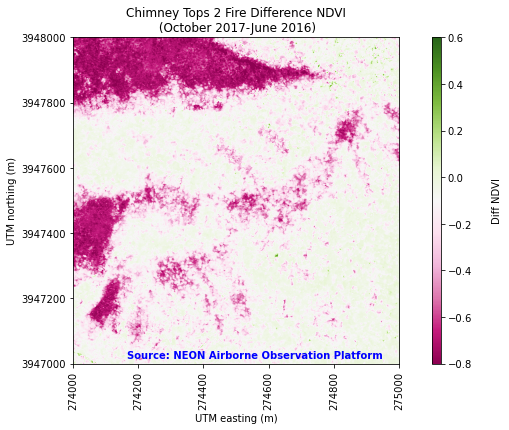

In [19]:
# Plot diff NDVI
fig, ax = plt.subplots(figsize=(12, 6))

plot = ax.imshow(diff_ndvi,
                 extent=post_fire_metadata['extent'],
                 cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff NDVI', rotation=90, labelpad=20)
plot.set_clim(-0.8, 0.6)

# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
ax.set(title='Chimney Tops 2 Fire Difference NDVI\n (October 2017-June 2016)',
       xlabel='UTM easting (m)',
       ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: NEON Airborne Observation Platform", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

* The plot of the post-pre NDVI shows remaining loss of greenness almost a year after the Chimney Tops 2 Fire. The most significant loss of vegetation are shown in pink.

### 3. Modified Soil Adjusted Vegetation Index (MSAVI)
* The MSAVI equation has been expanded for ease of computation from its original form of
$\frac{2NIR+1-\sqrt{(2NIR + 1)^{2}-8(NIR-Red)}}{2}$ to $NIR+0.5-0.5\sqrt{4NIR^{2}-4NIR+8Red+1}$
* The difference MSAVI is the difference between the post-fire MSAVI and the pre-fire MSAVI.

In [20]:
# Calculate MSAVI
pre_fire_msavi = refl.calc_msavi(
    pre_fire_stack[:,:,1], pre_fire_stack[:,:,0])
post_fire_msavi = refl.calc_msavi(
    post_fire_stack[:,:,1], post_fire_stack[:,:,0])

# Calculate diff MSAVI
diff_msavi = post_fire_msavi - pre_fire_msavi

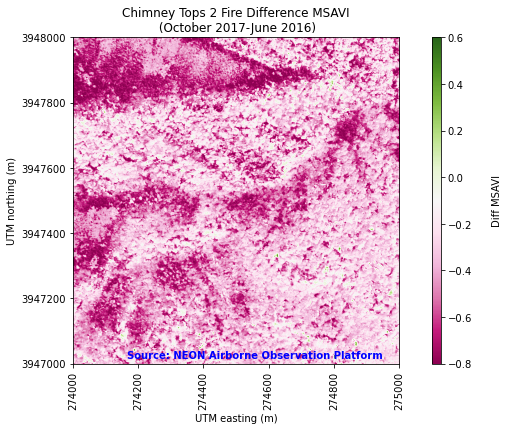

In [22]:
# Plot diff MSAVI
fig, ax = plt.subplots(figsize=(12, 6))

plot = plt.imshow(diff_msavi,
                  extent=post_fire_metadata['extent'],
                  cmap='PiYG')

# Color bar settings
cbar = plt.colorbar(plot, aspect=40)
cbar.set_label('Diff MSAVI', rotation=90, labelpad=20)


# Remove scientific notation from tile coordinates
ax.ticklabel_format(useOffset=False, style='plain')
plot.set_clim(-0.8, 0.6)

# Set figure title and axes labels
ax.set(title='Chimney Tops 2 Fire Difference MSAVI\n (October 2017-June 2016)',
       xlabel='UTM easting (m)',
       ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax.get_xticklabels(), rotation=90)

# Data source caption
ax.text(.95, .01, "Source: NEON Airborne Observation Platform", va='bottom',
         ha='right', transform=ax.transAxes, color="blue", fontweight="bold")

plt.show()

* The difference in post-pre MSAVI plot shows that the Chimney Tops region is still showing vegetation recovery within one year after the fire. MSAVI takes into account the soil-noise background. Upon comparison with the difference NDVI, the difference MSAVI plot suggests that the vegetation regrowth is small, since the soil-noise background is significant.

In [ ]:
# Plot diff NDVI and diff MSAVI together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot1 = ax1.imshow(diff_ndvi,
                  extent=post_fire_metadata['extent'],
                  cmap='PiYG')

plot2 = ax2.imshow(diff_msavi,
                  extent=post_fire_metadata['extent'],
                  cmap='PiYG')

# Color bar settings
cbr = ep.colorbar(plot1)
cbar = ep.colorbar(plot2)
cbar.set_label('Diff Vegetation Index', rotation=90, labelpad=20)

# Remove scientific notation from tile coordinates
ax1.ticklabel_format(useOffset=False, style='plain')
ax2.ticklabel_format(useOffset=False, style='plain')

# Set figure title and axes labels
fig.suptitle(
    "Comparison of NDVI & MSAVI for Post-Pre Chimney Tops 2 Fire", fontsize=16)
ax1.set(title='Difference NDVI\n (October 2017-June 2016)',
        xlabel='UTM easting (m)',
        ylabel='UTM northing (m)')
rotatexlabels = plt.setp(ax1.get_xticklabels(), rotation=90)
ax2.set(title='Difference MSAVI\n (October 2017-June 2016)',
        xlabel='UTM easting (m)')
rotatexlabels = plt.setp(ax2.get_xticklabels(), rotation=90)

# Data source caption
ax1.text(.95, .01, "Source: NEON Airborne Observation Platform", va='bottom',
         ha='right', transform=ax1.transAxes, color="blue", fontweight="bold")
ax2.text(.95, .01, "Source: NEON Airborne Observation Platform", va='bottom',
         ha='right', transform=ax2.transAxes, color="blue", fontweight="bold")

fig.tight_layout()
plt.show()